### EWMA

Exponentially Weighted Moving Average (EWMA) is a popular technique in time series analysis and forecasting that assigns exponentially decreasing weights to past observations, giving more significance to recent data points while gradually reducing the influence of older ones. This weighting scheme allows EWMA to capture short-term trends and adapt to changes in data patterns over time. It is commonly used for smoothing noisy time series data, identifying trends, and reducing the impact of outliers.

In [2]:
# Download dataset
!curl -O https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2036  100  2036    0     0   3068      0 --:--:-- --:--:-- --:--:--  3070


In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

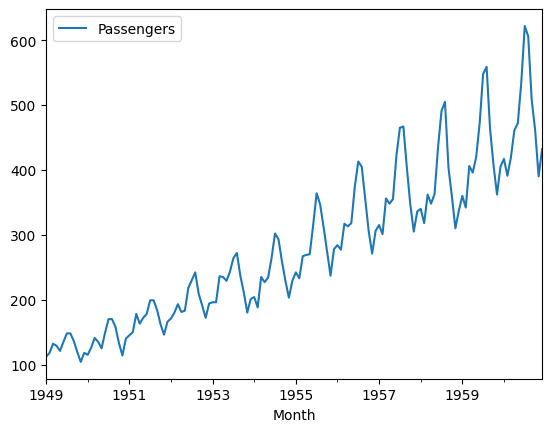

In [6]:
df.plot();

In [7]:
# Set alpha to 0.2
alpha = 0.2
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

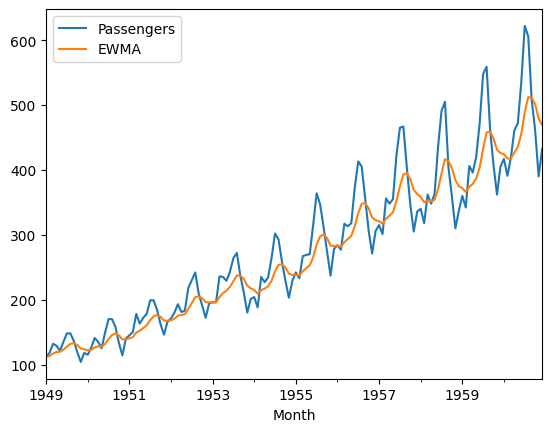

In [8]:
df.plot();

In [9]:
# Manually implement EWMA
manual_ewma = []
for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)
df['Manual'] = manual_ewma

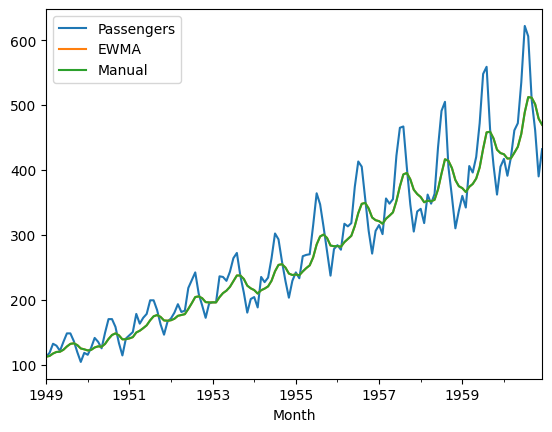

In [10]:
df.plot();

In [11]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [12]:
df.drop('Manual', axis=1, inplace=True)

### Siple Exponential Smoothing (SES)
Simple Exponential Smoothing is a fundamental time series forecasting method that is particularly useful for modeling and predicting data with a single, constant level of seasonality and no trend. This method relies on the principle that future values in a time series can be estimated as a weighted average of past observations, with exponentially decreasing weights assigned to older data points. The key component of Simple Exponential Smoothing is the smoothing parameter, often denoted as "alpha," which controls the weight given to the most recent observation and dampens the effect of older data points. This technique is widely used in applications where there is no strong trend or seasonality, making it a valuable tool for short-term forecasting and smoothing noisy time series data.

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses = SimpleExpSmoothing(df['Passengers'])

c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
# Set the frequency for df.index
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [17]:
df.index.freq = 'MS'

In [18]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic'
)

In [19]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [21]:
# Save predictions to df
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [22]:
np.allclose(df['SES'], res.fittedvalues)

True

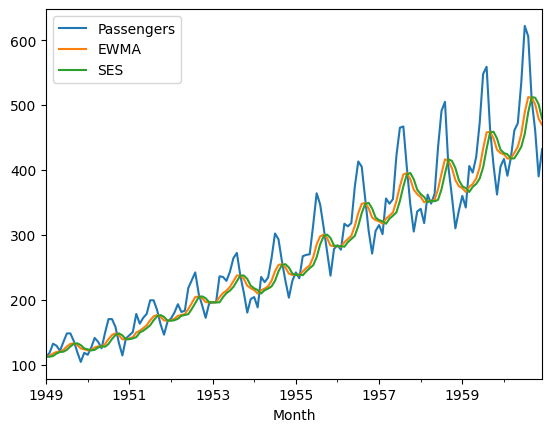

In [23]:
df.plot();

In [24]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [25]:
df['SES-1'] = df['SES'].shift(-1)

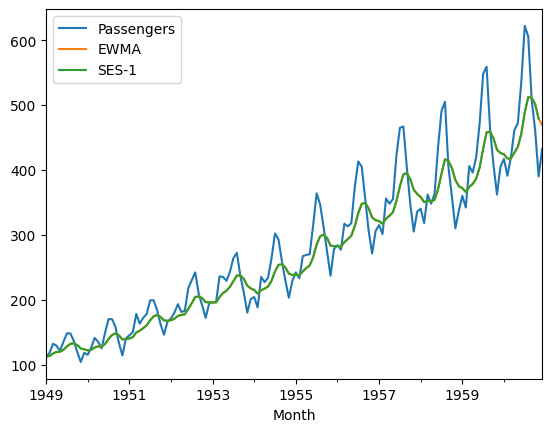

In [26]:
# Don't do shifting! It's wrong
# This is a forecast model. It's index is shifted up by one
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [27]:
# Treat it as ML problem
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[N_test:]

In [28]:
# No optimized=False in fit method
# We want SES to figure out the best alpha
res = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic'
).fit()

In [29]:
# Get train/test indices
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

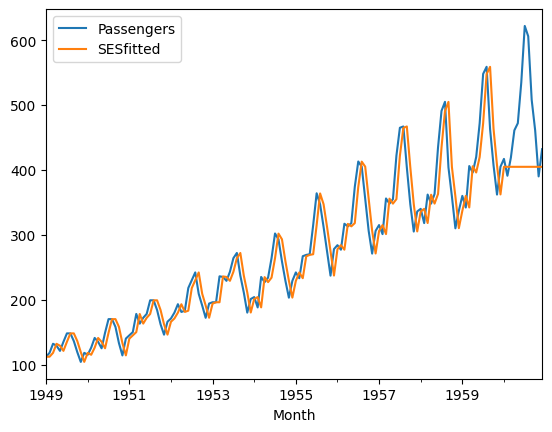

In [31]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues

# Do forecasting on test set
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)

df[['Passengers', 'SESfitted']].plot();

We can see that SES simply forecasts by a flat line.

In [32]:
# We can see alpha (smoothing_level)
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt linear model
Holt's linear model is a widely used time series forecasting method that captures trends in data.

The model includes two primary components: 
- Level (representing the baseline or average value)
- Trend (capturing the linear growth or decline)

By estimating and updating these components over time, Holt's linear model provides forecasts that adapt to the changing characteristics of the time series, making it a valuable tool for predictive analytics and decision-making.

In [33]:
from statsmodels.tsa.holtwinters import Holt

In [34]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic'
)

In [35]:
res_h = holt.fit()

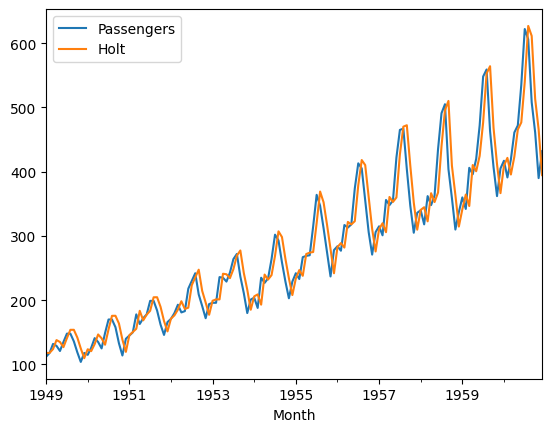

In [36]:
df['Holt'] = res_h.fittedvalues
df[['Passengers', 'Holt']].plot();

In [37]:
res_h = Holt(
    train['Passengers'],
    initialization_method='legacy-heuristic'
).fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

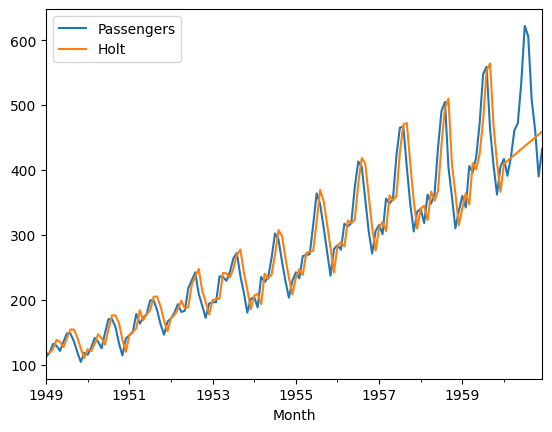

In [38]:
# Forecast: we can see a straightline trending upwards
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)
df[['Passengers', 'Holt']].plot();

### Holt-Winter's model

Holt-Winters, a widely used time series forecasting model, extends simple exponential smoothing by incorporating trend and seasonality components. It captures three main aspects of time series data: the **level, trend, and seasonality**. The model provides exponential smoothing for the level, a weighted average of the past trend, and a weighted average of the past seasonality.

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# First try additive method
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [40]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

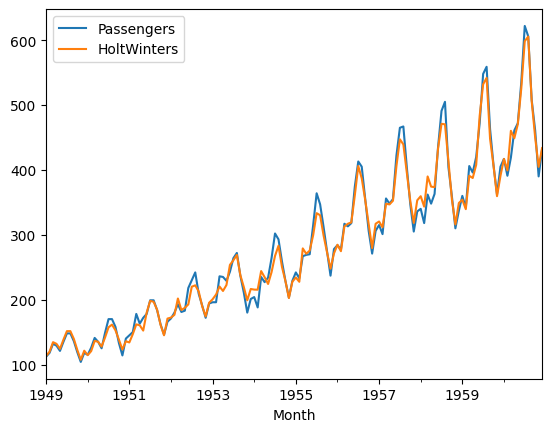

In [41]:
# We can see HW's model fits well
df[['Passengers', 'HoltWinters']].plot();

In [46]:
def rmse(pred, true):
    return np.sqrt(np.mean((pred - true) ** 2))

In [43]:
def mae(pred, true):
    return np.mean(np.abs(pred - true))

In [47]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.853000976828765
Test RMSE: 15.543003084126884


In [48]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 8.892127530485896
Test MAE: 10.43776563928059


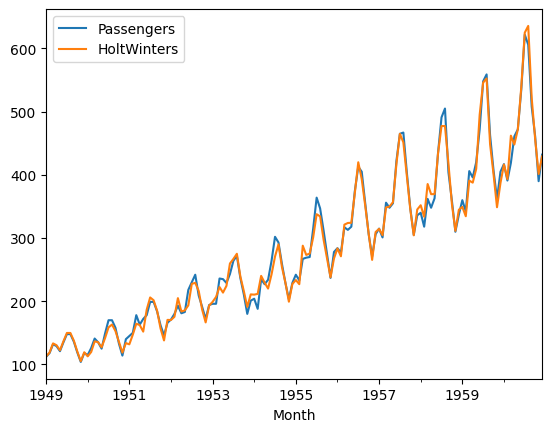

In [49]:
# Change to multiplication method
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [50]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 10.153934838980392
Test RMSE: 16.535212108255575


In [51]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.552052605073941
Test MAE: 10.683341165983848
